In [1]:
MUSCLE_MODEL_HOME = '/Users/rgerkin/dev/muscle_model' # Set this to your MUSCLE_MODEL repo location.  

import sys,os
import csv
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyneuroml
import django

from neuronunit.tests.channel import IVCurvePeakTest
from neuronunit.models.channel import ChannelModel
from pyneuroml.analysis import NML2ChannelAnalysis

In [2]:
# Load the experimental data (both calcium and potassium channels)
data_path = os.path.join(MUSCLE_MODEL_HOME,'BoyleCohen2008','data')
ca_peak_path = os.path.join(data_path,'ICa_pk.csv')
k_ss_path = os.path.join(data_path,'IK_ss.csv')

def read_current(path):
    """Read a single column from a csv file"""
    with open(path) as f:
        reader = csv.reader(f)
        current = [float(row[0]) for row in reader]
    return current

ca_peak_current = read_current(ca_peak_path)
k_ss_current = read_current(k_ss_path)
voltage = list(np.arange(-0.030,0.070,0.010)) # Determined by inspection of the figure that these are the corresponding voltages

# Instantiate the tests.  
observation = {'i':ca_peak_current, 'v':voltage}
ca_peak_test = IVCurvePeakTest(observation)
observation = {'i':k_ss_current, 'v':voltage}
k_ss_test = IVCurvePeakTest(observation)

In [3]:
# Instantiate the models

# Calcium peak
model_path = os.path.join(MUSCLE_MODEL_HOME,'NeuroML2')
ca_channel_name = 'ca_boyle.channel'
channel_id = 'ca_boyle'
ca_model_path = os.path.join(model_path,'%s.nml' % ca_channel_name)
ca_model = ChannelModel(ca_model_path,channel_index=0,name=ca_channel_name)

# Potassium steady state
k_channel_name = 'k_fast.channel'
channel_id = 'k_fast'
k_fast_model_path = os.path.join(model_path,'%s.nml' % k_channel_name)
k_fast_model = ChannelModel(k_fast_model_path,channel_index=0,name=k_channel_name)

In [4]:
# Judge the Ca channel model's output against the experimental data and print the score.  
ca_peak_score = ca_peak_test.judge(ca_model)
ca_peak_score.summarize()
print("The score was computed according to '%s' with raw value %s" % (ca_peak_score.description,ca_peak_score.value))

=== Model ca_boyle.channel (ChannelModel) achieved score Fail on test 'IV Curve Test (IVCurvePeakTest)'. ===
The score was computed according to 'The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.' with raw value 1180 pA^2


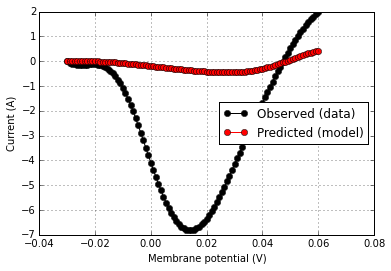

In [5]:
# Plot some output used by the test to compute the score.  
def plot_rd(score):
    rd = score.related_data
    score.plot(rd['v'],rd['i_obs'],color='k',label='Observed (data)')
    score.plot(rd['v'],rd['i_pred'],same_fig=True,color='r',label='Predicted (model)')
plot_rd(ca_peak_score)

# Move legend
axes = plt.gca()
_ = axes.legend(loc=5)

In [6]:
# Judge the fast K channel model's output against the experimental data and print the score.  
k_ss_score = k_ss_test.judge(k_fast_model)
k_ss_score.summarize()
print("The score was computed according to '%s' with raw value %s" % (k_ss_score.description,k_ss_score.value))

=== Model k_fast.channel (ChannelModel) achieved score Fail on test 'IV Curve Test (IVCurvePeakTest)'. ===
The score was computed according to 'The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.' with raw value 2.195e+04 pA^2


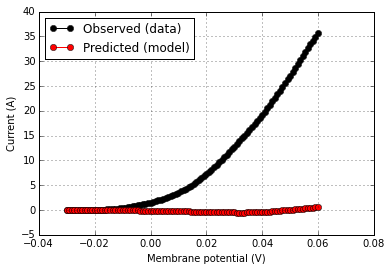

In [7]:
# Plot some output used by the test to compute the score.  
plot_rd(k_ss_score)

In [8]:
# Run the actual muscle cell model.  
muscle_model_xml = os.path.join(MUSCLE_MODEL_HOME,'NeuroML2','LEMS_NeuronMuscle.xml')
a = NML2ChannelAnalysis.build_namespace()
results = NML2ChannelAnalysis.run_lems_file(muscle_model_xml,a)

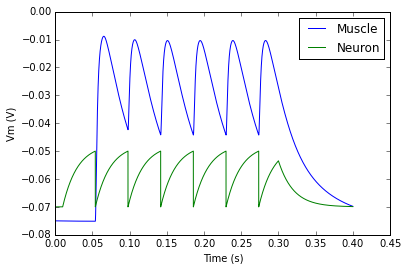

In [9]:
# Plot some model output.  
plt.plot(results['t'],results['muscle/0/SingleCompMuscleCell/v'],label='Muscle')
plt.plot(results['t'],results['neuron/0/generic_iaf_cell/v'],label='Neuron')
plt.xlabel('Time (s)')
plt.ylabel('Vm (V)')
plt.legend()

# TO DO: Figure out what to data to test this output against.  